In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Scalable Gaussian processes in PyMC3

PyMC3 has support for [Gaussian Processes (GPs)](https://docs.pymc.io/gp.html), but this implementation is too slow for many applications in time series astrophysics.
So *exoplanet* comes with an implementation of scalable GPs powered by [celerite](https://celerite.readthedocs.io/).
More information about the algorithm can be found in the [celerite docs](https://celerite.readthedocs.io/) and in the papers ([Paper 1](https://arxiv.org/abs/1703.09710) and [Paper 2](https://arxiv.org/abs/1801.10156)), but this tutorial will give a hands on demo of how to use celerite in PyMC3.

Let's start with the quickstart demo from the [celerite docs](https://celerite.readthedocs.io/en/stable/tutorials/first/).
We'll fit the following simulated dataset using the sum of two :class:`exoplanet.gp.terms.SHOTerm` objects.

First, generate the simulated data:

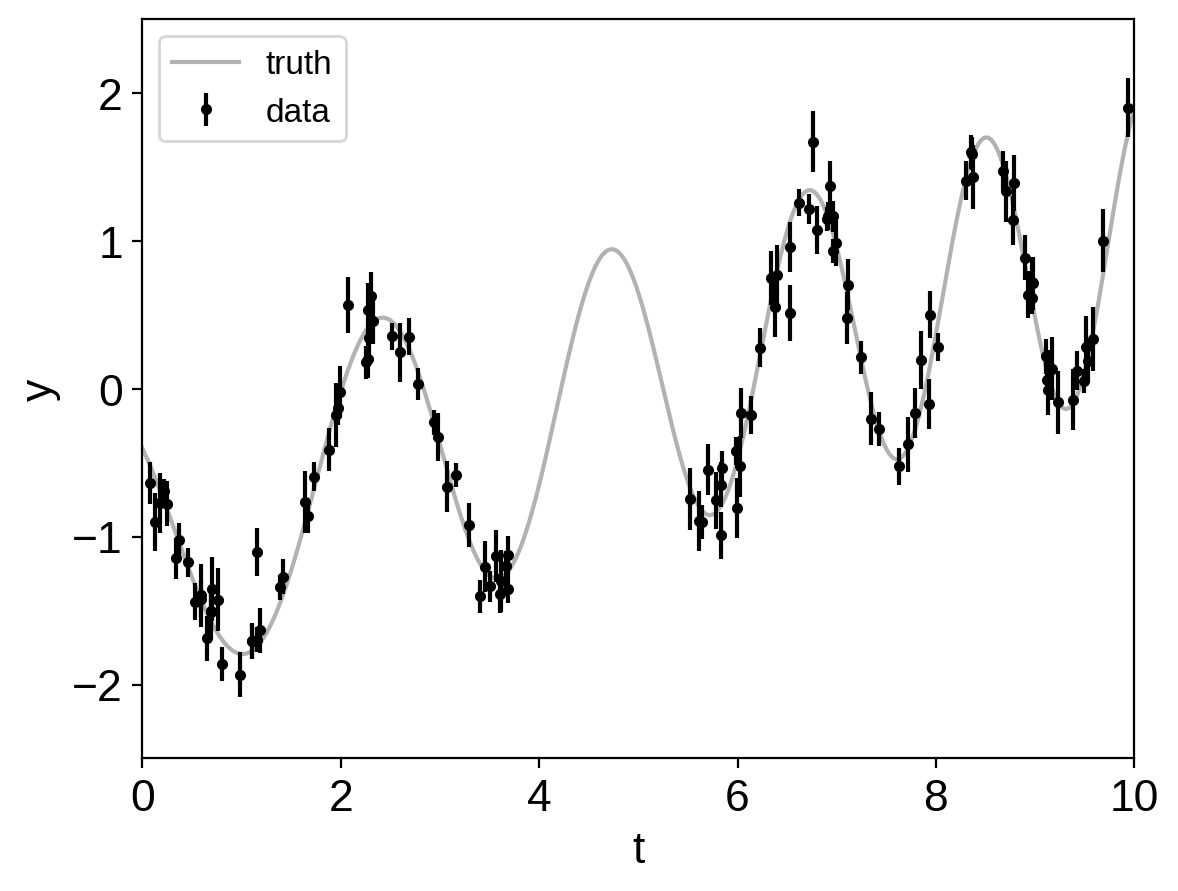

In [3]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

t = np.sort(
    np.append(np.random.uniform(0, 3.8, 57), np.random.uniform(5.5, 10, 68))
)  # The input coordinates must be sorted
yerr = np.random.uniform(0.08, 0.22, len(t))
y = (
    0.2 * (t - 5)
    + np.sin(3 * t + 0.1 * (t - 5) ** 2)
    + yerr * np.random.randn(len(t))
)

true_t = np.linspace(0, 10, 5000)
true_y = 0.2 * (true_t - 5) + np.sin(3 * true_t + 0.1 * (true_t - 5) ** 2)

plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, label="data")
plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3, label="truth")
plt.legend(fontsize=12)
plt.xlabel("t")
plt.ylabel("y")
plt.xlim(0, 10)
_ = plt.ylim(-2.5, 2.5)

This plot shows the simulated data as black points with error bars and
the true function is shown as a gray line.

Now let's build the PyMC3 model that we'll use to fit the data.
We can see that there's some roughly periodic signal in the data as well
as a longer term trend. To capture these two features, we will model
this as a mixture of two stochastically driven simple harmonic
oscillators (SHO) with the power spectrum:

$$
S(\omega) = \sqrt{\frac{2}{\pi}}\frac{S_1\,{\omega_1}^4}{(\omega^2 - {\omega_1}^2)^2 + 2\,{\omega_1}^2\,\omega^2}
   + \sqrt{\frac{2}{\pi}}\frac{S_2\,{\omega_2}^4}{(\omega^2 - {\omega_2}^2)^2 + {\omega_2}^2\,\omega^2/Q^2}
$$

The first term is :class:`exoplanet.gp.terms.SHOterm` with $Q=1/\sqrt{2}$ and the second is regular :class:`exoplanet.gp.terms.SHOterm`.
This model has 5 free parameters ($S_1$, $\omega_1$, $S_2$, $\omega_2$, and $Q$) and they must all be positive so we'll fit for the log of each parameter.
Using *exoplanet*, this is how you would build this model,
choosing more or less arbitrary initial values for the parameters.

In [4]:
import pymc3 as pm
import theano.tensor as tt
from exoplanet.gp import terms, GP

with pm.Model() as model:

    mean = pm.Normal("mean", mu=0.0, sigma=1.0)
    logS1 = pm.Normal("logS1", mu=0.0, sigma=15.0, testval=np.log(np.var(y)))
    logw1 = pm.Normal("logw1", mu=0.0, sigma=15.0, testval=np.log(3.0))
    logS2 = pm.Normal("logS2", mu=0.0, sigma=15.0, testval=np.log(np.var(y)))
    logw2 = pm.Normal("logw2", mu=0.0, sigma=15.0, testval=np.log(3.0))
    logQ = pm.Normal("logQ", mu=0.0, sigma=15.0, testval=0)

    # Set up the kernel an GP
    kernel = terms.SHOTerm(log_S0=logS1, log_w0=logw1, Q=1.0 / np.sqrt(2))
    kernel += terms.SHOTerm(log_S0=logS2, log_w0=logw2, log_Q=logQ)
    gp = GP(kernel, t, yerr ** 2, mean=mean)

    # Condition the GP on the observations and add the marginal likelihood
    # to the model
    gp.marginal("gp", observed=y)

A few comments here:

1. The `term` interface in *exoplanet* only accepts keyword arguments with names given by the `parameter_names` property of the term. But it will also interpret keyword arguments with the name prefaced by `log_` to be the log of the parameter. For example, in this case, we used `log_S0` as the parameter for each term, but `S0=tt.exp(log_S0)` would have been equivalent. This is useful because many of the parameters are required to be positive so fitting the log of those parameters is often best.
2. The third argument to the :class:`exoplanet.gp.GP` constructor should be the *variance* to add along the diagonal, not the standard deviation as in the original [celerite implementation](https://celerite.readthedocs.io).
3. Finally, the :class:`exoplanet.gp.GP` constructor takes an optional argument `J` which specifies the width of the problem if it is known at compile time. Just to be confusing, this is actually two times the `J` from [the celerite paper](https://arxiv.org/abs/1703.09710). There are various technical reasons why this is difficult to work out in general and this code will always work if you don't provide a value for `J`, but you can get much better performance (especially for small `J`) if you know what it will be for your problem. In general, most terms cost `J=2` with the exception of a :class:`exoplanet.gp.terms.RealTerm` (which costs `J=1`) and a :class:`exoplanet.gp.terms.RotationTerm` (which costs `J=4`).

To start, let's fit for the maximum a posteriori (MAP) parameters and look the the predictions that those make.

In [5]:
import exoplanet as xo

with model:
    map_soln = xo.optimize(start=model.test_point)

optimizing logp for variables: [logQ, logw2, logS2, logw1, logS1, mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-4.198757e+01]

1it [00:00, 302.95it/s, logp=-4.198757e+01]

2it [00:00, 361.86it/s, logp=-1.441157e+01]

3it [00:00, 408.20it/s, logp=-2.672791e+01]

4it [00:00, 441.35it/s, logp=-1.427864e+01]

5it [00:00, 458.30it/s, logp=-1.409530e+01]

6it [00:00, 477.43it/s, logp=-1.805457e+01]

7it [00:00, 494.28it/s, logp=-1.408273e+01]

8it [00:00, 507.69it/s, logp=-1.406092e+01]

9it [00:00, 498.72it/s, logp=-1.403897e+01]

10it [00:00, 505.75it/s, logp=-1.401718e+01]

11it [00:00, 515.06it/s, logp=-1.398992e+01]

12it [00:00, 524.69it/s, logp=-1.369576e+01]

13it [00:00, 507.87it/s, logp=-9.453963e+00]

14it [00:00, 504.48it/s, logp=-1.319547e+01]

15it [00:00, 507.29it/s, logp=-8.622752e+00]

16it [00:00, 505.64it/s, logp=-3.102259e+03]

17it [00:00, 508.64it/s, logp=-1.331491e+03]

18it [00:00, 513.83it/s, logp=-8.622743e+00]

19it [00:00, 513.78it/s, logp=-8.621741e+00]

20it [00:00, 514.25it/s, logp=-8.619707e+00]

21it [00:00, 511.46it/s, logp=-8.611686e+00]

22it [00:00, 510.62it/s, logp=-8.581493e+00]

23it [00:00, 507.14it/s, logp=-8.503612e+00]

24it [00:00, 508.90it/s, logp=-8.255917e+00]

25it [00:00, 510.27it/s, logp=-7.761902e+00]

26it [00:00, 509.42it/s, logp=-6.973240e+00]

27it [00:00, 510.29it/s, logp=-5.885993e+00]

28it [00:00, 512.26it/s, logp=-5.302349e+00]

29it [00:00, 511.59it/s, logp=-4.929723e+00]

30it [00:00, 508.51it/s, logp=-4.644468e+00]

31it [00:00, 509.91it/s, logp=-4.477202e+00]

32it [00:00, 510.57it/s, logp=-4.187378e+00]

33it [00:00, 508.43it/s, logp=-3.780570e+00]

34it [00:00, 508.17it/s, logp=-3.393474e+00]

35it [00:00, 509.59it/s, logp=-3.005105e+00]

36it [00:00, 507.78it/s, logp=-2.777381e+00]

37it [00:00, 506.72it/s, logp=-2.645186e+00]

38it [00:00, 505.79it/s, logp=-2.581381e+00]

39it [00:00, 503.62it/s, logp=-2.571726e+00]

40it [00:00, 502.86it/s, logp=-2.570059e+00]

41it [00:00, 502.07it/s, logp=-2.569910e+00]

42it [00:00, 500.58it/s, logp=-2.569898e+00]

43it [00:00, 500.14it/s, logp=-2.569894e+00]

44it [00:00, 496.61it/s, logp=-2.569893e+00]

45it [00:00, 495.57it/s, logp=-2.569892e+00]

46it [00:00, 496.80it/s, logp=-2.569892e+00]

47it [00:00, 497.87it/s, logp=-2.569892e+00]

48it [00:00, 494.49it/s, logp=-2.569892e+00]

49it [00:00, 72.32it/s, logp=-2.569892e+00] 


message: Optimization terminated successfully.
logp: -41.9875698144546 -> -2.5698921685734213


We'll use the :func:`exoplanet.eval_in_model` function to evaluate the MAP GP model.

In [6]:
with model:
    mu, var = xo.eval_in_model(gp.predict(true_t, return_var=True), map_soln)

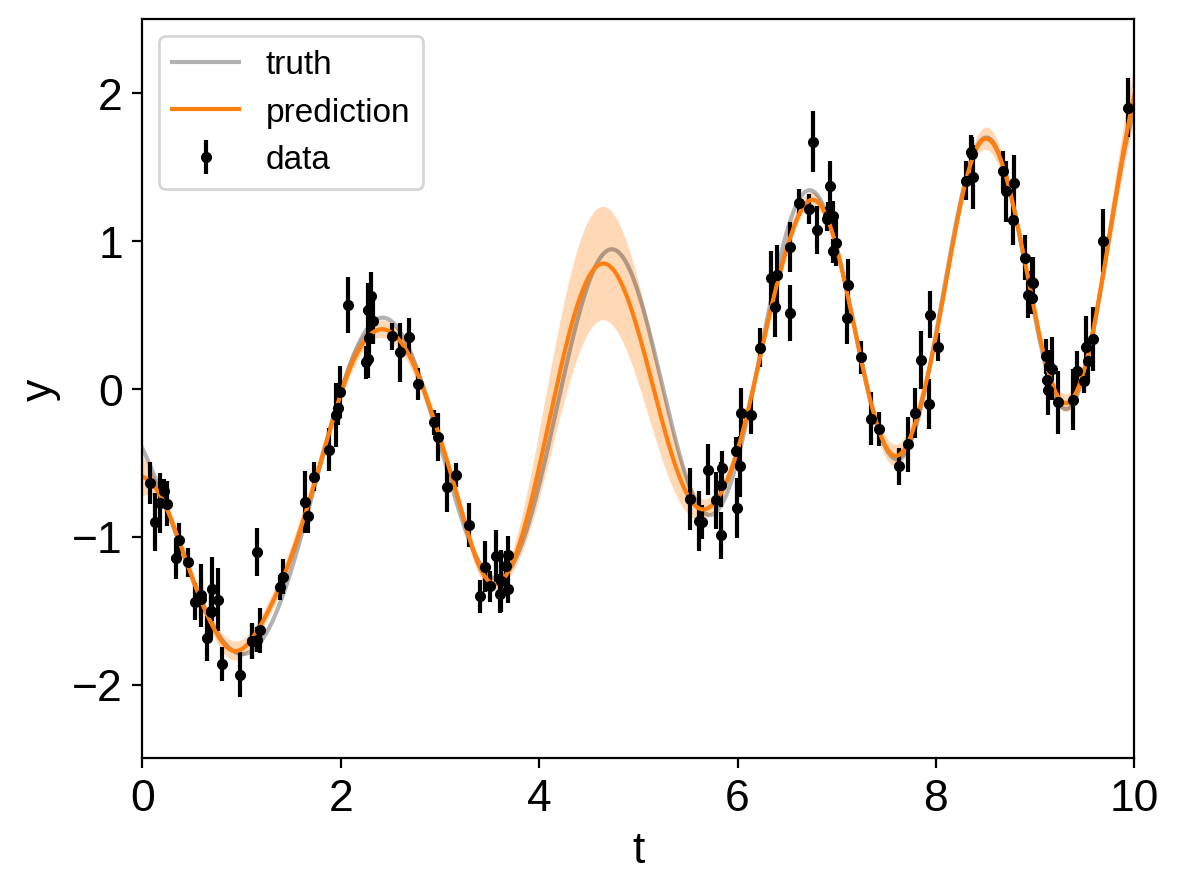

In [7]:
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, label="data")
plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3, label="truth")

# Plot the prediction and the 1-sigma uncertainty
sd = np.sqrt(var)
art = plt.fill_between(true_t, mu + sd, mu - sd, color="C1", alpha=0.3)
art.set_edgecolor("none")
plt.plot(true_t, mu, color="C1", label="prediction")

plt.legend(fontsize=12)
plt.xlabel("t")
plt.ylabel("y")
plt.xlim(0, 10)
_ = plt.ylim(-2.5, 2.5)

Now we can sample this model using PyMC3.
There are strong covariances between the parameters so we'll use the custom :func:`exoplanet.get_dense_nuts_step` to fit for these covariances during burn-in.

In [8]:
with model:
    trace = pm.sample(
        tune=2000,
        draws=2000,
        start=map_soln,
        cores=2,
        chains=2,
        step=xo.get_dense_nuts_step(target_accept=0.9),
    )

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [logQ, logw2, logS2, logw1, logS1, mean]


Sampling 2 chains, 0 divergences:   0%|          | 0/8000 [00:00<?, ?draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 5/8000 [00:00<05:17, 25.18draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 7/8000 [00:00<05:55, 22.50draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 9/8000 [00:00<06:29, 20.51draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 12/8000 [00:00<05:53, 22.63draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 14/8000 [00:00<06:10, 21.56draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 17/8000 [00:00<05:39, 23.50draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 21/8000 [00:00<05:09, 25.81draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 28/8000 [00:00<04:12, 31.62draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 32/8000 [00:01<04:26, 29.94draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 38/8000 [00:01<03:46, 35.20draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 44/8000 [00:01<03:36, 36.81draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 50/8000 [00:01<03:13, 40.99draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 57/8000 [00:01<02:51, 46.37draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 63/8000 [00:01<03:25, 38.60draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 68/8000 [00:01<03:28, 38.12draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 76/8000 [00:02<03:22, 39.11draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 81/8000 [00:02<03:54, 33.79draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 85/8000 [00:02<04:00, 32.84draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 89/8000 [00:02<04:04, 32.39draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 94/8000 [00:02<03:41, 35.63draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 101/8000 [00:02<03:12, 41.08draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 106/8000 [00:02<03:13, 40.80draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 111/8000 [00:03<03:21, 39.11draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 116/8000 [00:03<03:08, 41.74draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 121/8000 [00:03<03:23, 38.73draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 128/8000 [00:03<03:06, 42.10draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 133/8000 [00:03<03:06, 42.22draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 140/8000 [00:03<02:50, 46.04draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 147/8000 [00:03<02:36, 50.15draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 159/8000 [00:03<02:10, 59.94draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 166/8000 [00:03<02:07, 61.40draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 174/8000 [00:04<01:58, 65.83draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 186/8000 [00:04<01:46, 73.53draws/s]

Sampling 2 chains, 0 divergences:   2%|▎         | 200/8000 [00:04<01:33, 83.04draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 212/8000 [00:04<01:25, 91.46draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 227/8000 [00:04<01:16, 102.12draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 251/8000 [00:04<01:03, 122.75draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 273/8000 [00:04<00:55, 140.22draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 294/8000 [00:04<00:50, 153.71draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 314/8000 [00:04<00:46, 163.57draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 339/8000 [00:05<00:42, 182.08draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 361/8000 [00:05<00:39, 191.45draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 382/8000 [00:05<00:39, 194.26draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 403/8000 [00:05<00:41, 182.28draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 425/8000 [00:05<00:39, 191.66draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 447/8000 [00:05<00:38, 198.14draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 471/8000 [00:05<00:36, 205.42draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 493/8000 [00:05<00:38, 195.17draws/s]

Sampling 2 chains, 0 divergences:   6%|▋         | 517/8000 [00:05<00:36, 203.94draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 538/8000 [00:06<00:38, 194.49draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 561/8000 [00:06<00:36, 202.22draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 584/8000 [00:06<00:35, 206.96draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 609/8000 [00:06<00:34, 215.54draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 631/8000 [00:06<00:34, 214.17draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 653/8000 [00:06<00:34, 213.62draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 677/8000 [00:06<00:33, 219.57draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 700/8000 [00:06<00:34, 213.19draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 722/8000 [00:06<00:34, 210.28draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 744/8000 [00:07<00:34, 211.58draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 766/8000 [00:07<00:36, 196.14draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 790/8000 [00:07<00:35, 205.81draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 811/8000 [00:07<00:35, 203.88draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 832/8000 [00:07<00:37, 192.57draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 852/8000 [00:07<00:37, 193.05draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 873/8000 [00:07<00:36, 196.92draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 897/8000 [00:07<00:34, 206.20draws/s]

Sampling 2 chains, 0 divergences:  11%|█▏        | 918/8000 [00:07<00:35, 200.22draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 940/8000 [00:07<00:34, 203.74draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 961/8000 [00:08<00:36, 192.95draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 982/8000 [00:08<00:35, 197.15draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 1007/8000 [00:08<00:33, 208.53draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 1032/8000 [00:08<00:31, 217.99draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 1055/8000 [00:08<00:34, 203.03draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 1076/8000 [00:08<00:35, 194.43draws/s]

Sampling 2 chains, 0 divergences:  14%|█▎        | 1099/8000 [00:08<00:34, 200.67draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 1120/8000 [00:08<00:34, 199.62draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 1141/8000 [00:09<00:36, 190.09draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 1162/8000 [00:09<00:35, 194.67draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 1186/8000 [00:09<00:33, 201.15draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 1207/8000 [00:09<00:33, 200.94draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 1231/8000 [00:09<00:32, 210.30draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 1253/8000 [00:09<00:32, 205.37draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 1274/8000 [00:09<00:33, 203.42draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 1297/8000 [00:09<00:31, 210.49draws/s]

Sampling 2 chains, 0 divergences:  16%|█▋        | 1319/8000 [00:09<00:32, 203.33draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 1340/8000 [00:09<00:33, 201.12draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 1362/8000 [00:10<00:32, 205.69draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 1383/8000 [00:10<00:32, 203.85draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 1405/8000 [00:10<00:31, 208.35draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 1426/8000 [00:10<00:32, 204.46draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 1450/8000 [00:10<00:30, 211.57draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 1472/8000 [00:10<00:32, 200.72draws/s]

Sampling 2 chains, 0 divergences:  19%|█▊        | 1495/8000 [00:10<00:31, 208.14draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 1522/8000 [00:10<00:29, 222.47draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 1547/8000 [00:10<00:28, 228.35draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 1571/8000 [00:11<00:29, 216.96draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 1594/8000 [00:11<00:30, 211.24draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 1616/8000 [00:11<00:30, 208.52draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 1638/8000 [00:11<00:31, 200.71draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 1659/8000 [00:11<00:32, 192.56draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 1679/8000 [00:11<00:32, 193.64draws/s]

Sampling 2 chains, 0 divergences:  21%|██▏       | 1707/8000 [00:11<00:29, 211.92draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 1733/8000 [00:11<00:28, 223.82draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 1759/8000 [00:11<00:26, 232.38draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 1789/8000 [00:12<00:24, 248.92draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 1815/8000 [00:12<00:24, 249.62draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 1841/8000 [00:12<00:26, 230.37draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 1865/8000 [00:12<00:27, 223.80draws/s]

Sampling 2 chains, 0 divergences:  24%|██▎       | 1888/8000 [00:12<00:30, 203.19draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 1910/8000 [00:12<00:31, 193.68draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 1935/8000 [00:12<00:29, 205.91draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 1957/8000 [00:12<00:29, 204.08draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 1978/8000 [00:12<00:30, 198.48draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 1999/8000 [00:13<00:31, 192.82draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 2020/8000 [00:13<00:30, 195.33draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 2040/8000 [00:13<00:31, 191.34draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 2063/8000 [00:13<00:29, 198.98draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 2088/8000 [00:13<00:28, 210.71draws/s]

Sampling 2 chains, 0 divergences:  26%|██▋       | 2110/8000 [00:13<00:27, 213.13draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 2132/8000 [00:13<00:27, 212.13draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 2154/8000 [00:13<00:28, 207.82draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 2176/8000 [00:13<00:27, 211.28draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 2198/8000 [00:14<00:28, 201.77draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 2222/8000 [00:14<00:27, 209.14draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 2244/8000 [00:14<00:28, 201.01draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 2265/8000 [00:14<00:28, 201.08draws/s]

Sampling 2 chains, 0 divergences:  29%|██▊       | 2288/8000 [00:14<00:27, 207.49draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 2310/8000 [00:14<00:27, 206.93draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 2336/8000 [00:14<00:25, 219.06draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 2359/8000 [00:14<00:25, 219.44draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 2382/8000 [00:14<00:25, 217.78draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 2408/8000 [00:14<00:24, 228.90draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 2432/8000 [00:15<00:24, 224.60draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 2455/8000 [00:15<00:25, 217.88draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 2478/8000 [00:15<00:25, 219.78draws/s]

Sampling 2 chains, 0 divergences:  31%|███▏      | 2503/8000 [00:15<00:24, 225.74draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 2526/8000 [00:15<00:24, 221.26draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 2549/8000 [00:15<00:25, 217.18draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 2571/8000 [00:15<00:26, 205.15draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 2592/8000 [00:15<00:27, 198.59draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 2617/8000 [00:15<00:25, 210.68draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 2640/8000 [00:16<00:24, 215.24draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 2662/8000 [00:16<00:25, 207.01draws/s]

Sampling 2 chains, 0 divergences:  34%|███▎      | 2685/8000 [00:16<00:25, 211.32draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 2708/8000 [00:16<00:24, 214.49draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 2730/8000 [00:16<00:26, 197.16draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 2751/8000 [00:16<00:26, 199.52draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 2772/8000 [00:16<00:26, 197.85draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 2792/8000 [00:16<00:26, 197.98draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 2813/8000 [00:16<00:25, 201.16draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 2834/8000 [00:17<00:25, 201.71draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 2855/8000 [00:17<00:26, 193.01draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 2875/8000 [00:17<00:27, 189.09draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 2895/8000 [00:17<00:28, 182.20draws/s]

Sampling 2 chains, 0 divergences:  36%|███▋      | 2916/8000 [00:17<00:27, 186.35draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 2940/8000 [00:17<00:25, 198.51draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 2961/8000 [00:17<00:25, 197.96draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 2983/8000 [00:17<00:24, 202.36draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 3005/8000 [00:17<00:24, 207.18draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 3027/8000 [00:18<00:23, 210.32draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 3049/8000 [00:18<00:24, 202.09draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 3074/8000 [00:18<00:23, 213.02draws/s]

Sampling 2 chains, 0 divergences:  39%|███▊      | 3097/8000 [00:18<00:22, 214.60draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 3119/8000 [00:18<00:23, 211.95draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 3141/8000 [00:18<00:22, 212.27draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 3165/8000 [00:18<00:22, 219.50draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 3188/8000 [00:18<00:22, 215.19draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 3210/8000 [00:18<00:22, 211.62draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 3235/8000 [00:18<00:21, 219.13draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 3258/8000 [00:19<00:22, 214.93draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 3280/8000 [00:19<00:23, 204.27draws/s]

Sampling 2 chains, 0 divergences:  41%|████▏     | 3303/8000 [00:19<00:22, 208.75draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 3326/8000 [00:19<00:21, 214.39draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 3348/8000 [00:19<00:21, 214.10draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 3370/8000 [00:19<00:24, 189.55draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 3390/8000 [00:19<00:24, 190.48draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 3410/8000 [00:19<00:25, 181.86draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 3430/8000 [00:19<00:24, 186.85draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 3452/8000 [00:20<00:23, 194.12draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 3475/8000 [00:20<00:22, 200.60draws/s]

Sampling 2 chains, 0 divergences:  44%|████▎     | 3497/8000 [00:20<00:21, 205.69draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 3519/8000 [00:20<00:21, 206.24draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 3541/8000 [00:20<00:21, 207.69draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 3562/8000 [00:20<00:22, 200.80draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 3588/8000 [00:20<00:20, 213.24draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 3610/8000 [00:20<00:20, 212.45draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 3633/8000 [00:20<00:20, 217.09draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 3655/8000 [00:21<00:19, 217.35draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 3678/8000 [00:21<00:19, 219.10draws/s]

Sampling 2 chains, 0 divergences:  46%|████▋     | 3700/8000 [00:21<00:20, 209.03draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 3722/8000 [00:21<00:21, 196.08draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 3743/8000 [00:21<00:21, 198.95draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 3764/8000 [00:21<00:21, 195.91draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 3784/8000 [00:21<00:22, 189.43draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 3805/8000 [00:21<00:21, 192.24draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 3825/8000 [00:21<00:22, 188.71draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 3846/8000 [00:22<00:21, 194.27draws/s]

Sampling 2 chains, 1 divergences:  48%|████▊     | 3847/8000 [00:22<00:21, 194.27draws/s]

Sampling 2 chains, 1 divergences:  48%|████▊     | 3866/8000 [00:22<00:21, 195.49draws/s]

Sampling 2 chains, 1 divergences:  49%|████▊     | 3886/8000 [00:22<00:21, 191.94draws/s]

Sampling 2 chains, 1 divergences:  49%|████▉     | 3908/8000 [00:22<00:20, 199.28draws/s]

Sampling 2 chains, 1 divergences:  49%|████▉     | 3934/8000 [00:22<00:19, 211.39draws/s]

Sampling 2 chains, 1 divergences:  49%|████▉     | 3956/8000 [00:22<00:19, 211.39draws/s]

Sampling 2 chains, 1 divergences:  50%|████▉     | 3978/8000 [00:22<00:19, 205.06draws/s]

Sampling 2 chains, 1 divergences:  50%|█████     | 4000/8000 [00:22<00:19, 206.25draws/s]

Sampling 2 chains, 1 divergences:  50%|█████     | 4021/8000 [00:22<00:20, 194.55draws/s]

Sampling 2 chains, 1 divergences:  51%|█████     | 4041/8000 [00:22<00:20, 190.80draws/s]

Sampling 2 chains, 1 divergences:  51%|█████     | 4062/8000 [00:23<00:20, 193.19draws/s]

Sampling 2 chains, 1 divergences:  51%|█████     | 4088/8000 [00:23<00:18, 208.60draws/s]

Sampling 2 chains, 1 divergences:  51%|█████▏    | 4112/8000 [00:23<00:18, 213.64draws/s]

Sampling 2 chains, 1 divergences:  52%|█████▏    | 4137/8000 [00:23<00:17, 219.91draws/s]

Sampling 2 chains, 1 divergences:  52%|█████▏    | 4160/8000 [00:23<00:17, 219.63draws/s]

Sampling 2 chains, 1 divergences:  52%|█████▏    | 4183/8000 [00:23<00:17, 221.56draws/s]

Sampling 2 chains, 1 divergences:  53%|█████▎    | 4212/8000 [00:23<00:15, 237.86draws/s]

Sampling 2 chains, 1 divergences:  53%|█████▎    | 4237/8000 [00:23<00:16, 232.98draws/s]

Sampling 2 chains, 1 divergences:  53%|█████▎    | 4261/8000 [00:23<00:16, 222.48draws/s]

Sampling 2 chains, 1 divergences:  54%|█████▎    | 4286/8000 [00:24<00:16, 229.97draws/s]

Sampling 2 chains, 1 divergences:  54%|█████▍    | 4310/8000 [00:24<00:16, 227.98draws/s]

Sampling 2 chains, 1 divergences:  54%|█████▍    | 4334/8000 [00:24<00:16, 224.57draws/s]

Sampling 2 chains, 1 divergences:  55%|█████▍    | 4362/8000 [00:24<00:15, 234.95draws/s]

Sampling 2 chains, 1 divergences:  55%|█████▍    | 4386/8000 [00:24<00:15, 233.45draws/s]

Sampling 2 chains, 1 divergences:  55%|█████▌    | 4410/8000 [00:24<00:15, 228.59draws/s]

Sampling 2 chains, 1 divergences:  55%|█████▌    | 4435/8000 [00:24<00:15, 231.58draws/s]

Sampling 2 chains, 1 divergences:  56%|█████▌    | 4459/8000 [00:24<00:15, 229.63draws/s]

Sampling 2 chains, 1 divergences:  56%|█████▌    | 4483/8000 [00:24<00:15, 232.37draws/s]

Sampling 2 chains, 1 divergences:  56%|█████▋    | 4507/8000 [00:25<00:15, 223.38draws/s]

Sampling 2 chains, 1 divergences:  57%|█████▋    | 4530/8000 [00:25<00:16, 214.18draws/s]

Sampling 2 chains, 1 divergences:  57%|█████▋    | 4552/8000 [00:25<00:16, 213.67draws/s]

Sampling 2 chains, 1 divergences:  57%|█████▋    | 4577/8000 [00:25<00:15, 219.65draws/s]

Sampling 2 chains, 1 divergences:  57%|█████▊    | 4600/8000 [00:25<00:15, 215.50draws/s]

Sampling 2 chains, 1 divergences:  58%|█████▊    | 4622/8000 [00:25<00:15, 215.65draws/s]

Sampling 2 chains, 1 divergences:  58%|█████▊    | 4648/8000 [00:25<00:14, 223.65draws/s]

Sampling 2 chains, 1 divergences:  58%|█████▊    | 4671/8000 [00:25<00:14, 223.96draws/s]

Sampling 2 chains, 1 divergences:  59%|█████▊    | 4695/8000 [00:25<00:14, 228.17draws/s]

Sampling 2 chains, 1 divergences:  59%|█████▉    | 4718/8000 [00:25<00:15, 210.46draws/s]

Sampling 2 chains, 1 divergences:  59%|█████▉    | 4740/8000 [00:26<00:15, 207.55draws/s]

Sampling 2 chains, 1 divergences:  60%|█████▉    | 4766/8000 [00:26<00:14, 219.74draws/s]

Sampling 2 chains, 1 divergences:  60%|█████▉    | 4791/8000 [00:26<00:14, 225.73draws/s]

Sampling 2 chains, 1 divergences:  60%|██████    | 4814/8000 [00:26<00:14, 217.02draws/s]

Sampling 2 chains, 1 divergences:  60%|██████    | 4836/8000 [00:26<00:14, 213.96draws/s]

Sampling 2 chains, 1 divergences:  61%|██████    | 4858/8000 [00:26<00:14, 210.94draws/s]

Sampling 2 chains, 1 divergences:  61%|██████    | 4880/8000 [00:26<00:14, 209.95draws/s]

Sampling 2 chains, 1 divergences:  61%|██████▏   | 4902/8000 [00:26<00:14, 212.66draws/s]

Sampling 2 chains, 1 divergences:  62%|██████▏   | 4924/8000 [00:26<00:14, 214.80draws/s]

Sampling 2 chains, 1 divergences:  62%|██████▏   | 4946/8000 [00:27<00:14, 213.07draws/s]

Sampling 2 chains, 1 divergences:  62%|██████▏   | 4969/8000 [00:27<00:14, 216.41draws/s]

Sampling 2 chains, 1 divergences:  62%|██████▏   | 4991/8000 [00:27<00:14, 210.66draws/s]

Sampling 2 chains, 1 divergences:  63%|██████▎   | 5016/8000 [00:27<00:13, 220.24draws/s]

Sampling 2 chains, 1 divergences:  63%|██████▎   | 5039/8000 [00:27<00:13, 222.67draws/s]

Sampling 2 chains, 1 divergences:  63%|██████▎   | 5062/8000 [00:27<00:13, 220.23draws/s]

Sampling 2 chains, 1 divergences:  64%|██████▎   | 5085/8000 [00:27<00:13, 215.04draws/s]

Sampling 2 chains, 1 divergences:  64%|██████▍   | 5107/8000 [00:27<00:13, 207.46draws/s]

Sampling 2 chains, 1 divergences:  64%|██████▍   | 5129/8000 [00:27<00:13, 211.03draws/s]

Sampling 2 chains, 1 divergences:  64%|██████▍   | 5151/8000 [00:28<00:13, 206.76draws/s]

Sampling 2 chains, 1 divergences:  65%|██████▍   | 5177/8000 [00:28<00:13, 214.50draws/s]

Sampling 2 chains, 1 divergences:  65%|██████▍   | 5199/8000 [00:28<00:13, 213.44draws/s]

Sampling 2 chains, 1 divergences:  65%|██████▌   | 5221/8000 [00:28<00:13, 210.21draws/s]

Sampling 2 chains, 1 divergences:  66%|██████▌   | 5245/8000 [00:28<00:12, 216.48draws/s]

Sampling 2 chains, 1 divergences:  66%|██████▌   | 5269/8000 [00:28<00:12, 222.57draws/s]

Sampling 2 chains, 1 divergences:  66%|██████▌   | 5292/8000 [00:28<00:12, 216.42draws/s]

Sampling 2 chains, 1 divergences:  66%|██████▋   | 5314/8000 [00:28<00:12, 216.17draws/s]

Sampling 2 chains, 1 divergences:  67%|██████▋   | 5339/8000 [00:28<00:12, 219.88draws/s]

Sampling 2 chains, 1 divergences:  67%|██████▋   | 5362/8000 [00:28<00:12, 213.10draws/s]

Sampling 2 chains, 1 divergences:  67%|██████▋   | 5384/8000 [00:29<00:12, 207.64draws/s]

Sampling 2 chains, 1 divergences:  68%|██████▊   | 5408/8000 [00:29<00:12, 214.44draws/s]

Sampling 2 chains, 1 divergences:  68%|██████▊   | 5433/8000 [00:29<00:11, 220.10draws/s]

Sampling 2 chains, 1 divergences:  68%|██████▊   | 5456/8000 [00:29<00:11, 222.27draws/s]

Sampling 2 chains, 1 divergences:  68%|██████▊   | 5479/8000 [00:29<00:11, 216.48draws/s]

Sampling 2 chains, 1 divergences:  69%|██████▉   | 5501/8000 [00:29<00:11, 215.21draws/s]

Sampling 2 chains, 1 divergences:  69%|██████▉   | 5523/8000 [00:29<00:11, 214.69draws/s]

Sampling 2 chains, 1 divergences:  69%|██████▉   | 5545/8000 [00:29<00:11, 214.49draws/s]

Sampling 2 chains, 1 divergences:  70%|██████▉   | 5567/8000 [00:29<00:11, 212.02draws/s]

Sampling 2 chains, 1 divergences:  70%|██████▉   | 5592/8000 [00:30<00:11, 215.42draws/s]

Sampling 2 chains, 1 divergences:  70%|███████   | 5614/8000 [00:30<00:11, 216.19draws/s]

Sampling 2 chains, 2 divergences:  70%|███████   | 5632/8000 [00:30<00:10, 216.19draws/s]

Sampling 2 chains, 2 divergences:  70%|███████   | 5636/8000 [00:30<00:11, 213.35draws/s]

Sampling 2 chains, 2 divergences:  71%|███████   | 5660/8000 [00:30<00:10, 220.44draws/s]

Sampling 2 chains, 2 divergences:  71%|███████   | 5683/8000 [00:30<00:10, 221.72draws/s]

Sampling 2 chains, 2 divergences:  71%|███████▏  | 5706/8000 [00:30<00:10, 216.02draws/s]

Sampling 2 chains, 2 divergences:  72%|███████▏  | 5728/8000 [00:30<00:10, 210.96draws/s]

Sampling 2 chains, 2 divergences:  72%|███████▏  | 5751/8000 [00:30<00:10, 215.38draws/s]

Sampling 2 chains, 2 divergences:  72%|███████▏  | 5773/8000 [00:30<00:10, 214.90draws/s]

Sampling 2 chains, 2 divergences:  72%|███████▏  | 5795/8000 [00:30<00:10, 216.38draws/s]

Sampling 2 chains, 2 divergences:  73%|███████▎  | 5818/8000 [00:31<00:09, 219.87draws/s]

Sampling 2 chains, 2 divergences:  73%|███████▎  | 5842/8000 [00:31<00:09, 222.96draws/s]

Sampling 2 chains, 2 divergences:  73%|███████▎  | 5866/8000 [00:31<00:09, 226.01draws/s]

Sampling 2 chains, 2 divergences:  74%|███████▎  | 5889/8000 [00:31<00:09, 222.07draws/s]

Sampling 2 chains, 2 divergences:  74%|███████▍  | 5912/8000 [00:31<00:09, 216.04draws/s]

Sampling 2 chains, 2 divergences:  74%|███████▍  | 5935/8000 [00:31<00:09, 217.74draws/s]

Sampling 2 chains, 2 divergences:  74%|███████▍  | 5957/8000 [00:31<00:09, 217.02draws/s]

Sampling 2 chains, 2 divergences:  75%|███████▍  | 5979/8000 [00:31<00:09, 209.12draws/s]

Sampling 2 chains, 2 divergences:  75%|███████▌  | 6003/8000 [00:31<00:09, 214.58draws/s]

Sampling 2 chains, 2 divergences:  75%|███████▌  | 6025/8000 [00:32<00:09, 213.91draws/s]

Sampling 2 chains, 2 divergences:  76%|███████▌  | 6047/8000 [00:32<00:09, 214.88draws/s]

Sampling 2 chains, 2 divergences:  76%|███████▌  | 6069/8000 [00:32<00:09, 208.73draws/s]

Sampling 2 chains, 2 divergences:  76%|███████▌  | 6093/8000 [00:32<00:08, 215.99draws/s]

Sampling 2 chains, 2 divergences:  76%|███████▋  | 6115/8000 [00:32<00:08, 213.95draws/s]

Sampling 2 chains, 2 divergences:  77%|███████▋  | 6139/8000 [00:32<00:08, 219.00draws/s]

Sampling 2 chains, 2 divergences:  77%|███████▋  | 6161/8000 [00:32<00:08, 217.67draws/s]

Sampling 2 chains, 2 divergences:  77%|███████▋  | 6183/8000 [00:32<00:08, 217.66draws/s]

Sampling 2 chains, 2 divergences:  78%|███████▊  | 6205/8000 [00:32<00:08, 209.17draws/s]

Sampling 2 chains, 2 divergences:  78%|███████▊  | 6227/8000 [00:32<00:08, 208.92draws/s]

Sampling 2 chains, 2 divergences:  78%|███████▊  | 6253/8000 [00:33<00:07, 219.59draws/s]

Sampling 2 chains, 2 divergences:  78%|███████▊  | 6279/8000 [00:33<00:07, 228.02draws/s]

Sampling 2 chains, 2 divergences:  79%|███████▉  | 6303/8000 [00:33<00:07, 229.89draws/s]

Sampling 2 chains, 2 divergences:  79%|███████▉  | 6327/8000 [00:33<00:07, 230.74draws/s]

Sampling 2 chains, 2 divergences:  79%|███████▉  | 6352/8000 [00:33<00:06, 236.09draws/s]

Sampling 2 chains, 2 divergences:  80%|███████▉  | 6376/8000 [00:33<00:07, 228.40draws/s]

Sampling 2 chains, 2 divergences:  80%|████████  | 6400/8000 [00:33<00:06, 230.97draws/s]

Sampling 2 chains, 2 divergences:  80%|████████  | 6424/8000 [00:33<00:07, 221.08draws/s]

Sampling 2 chains, 2 divergences:  81%|████████  | 6449/8000 [00:33<00:06, 222.88draws/s]

Sampling 2 chains, 2 divergences:  81%|████████  | 6472/8000 [00:34<00:06, 221.45draws/s]

Sampling 2 chains, 2 divergences:  81%|████████  | 6495/8000 [00:34<00:06, 223.22draws/s]

Sampling 2 chains, 2 divergences:  81%|████████▏ | 6518/8000 [00:34<00:06, 217.56draws/s]

Sampling 2 chains, 2 divergences:  82%|████████▏ | 6540/8000 [00:34<00:06, 214.51draws/s]

Sampling 2 chains, 2 divergences:  82%|████████▏ | 6566/8000 [00:34<00:06, 219.85draws/s]

Sampling 2 chains, 2 divergences:  82%|████████▏ | 6589/8000 [00:34<00:06, 216.80draws/s]

Sampling 2 chains, 2 divergences:  83%|████████▎ | 6614/8000 [00:34<00:06, 224.35draws/s]

Sampling 2 chains, 2 divergences:  83%|████████▎ | 6637/8000 [00:34<00:06, 215.52draws/s]

Sampling 2 chains, 2 divergences:  83%|████████▎ | 6661/8000 [00:34<00:06, 220.23draws/s]

Sampling 2 chains, 2 divergences:  84%|████████▎ | 6685/8000 [00:35<00:05, 224.59draws/s]

Sampling 2 chains, 3 divergences:  84%|████████▍ | 6700/8000 [00:35<00:05, 224.59draws/s]

Sampling 2 chains, 3 divergences:  84%|████████▍ | 6708/8000 [00:35<00:06, 209.63draws/s]

Sampling 2 chains, 3 divergences:  84%|████████▍ | 6730/8000 [00:35<00:06, 206.54draws/s]

Sampling 2 chains, 3 divergences:  84%|████████▍ | 6751/8000 [00:35<00:06, 206.95draws/s]

Sampling 2 chains, 3 divergences:  85%|████████▍ | 6774/8000 [00:35<00:05, 212.08draws/s]

Sampling 2 chains, 3 divergences:  85%|████████▍ | 6796/8000 [00:35<00:05, 209.01draws/s]

Sampling 2 chains, 3 divergences:  85%|████████▌ | 6820/8000 [00:35<00:05, 214.87draws/s]

Sampling 2 chains, 3 divergences:  86%|████████▌ | 6842/8000 [00:35<00:05, 213.62draws/s]

Sampling 2 chains, 3 divergences:  86%|████████▌ | 6865/8000 [00:35<00:05, 217.78draws/s]

Sampling 2 chains, 3 divergences:  86%|████████▌ | 6887/8000 [00:35<00:05, 215.88draws/s]

Sampling 2 chains, 3 divergences:  86%|████████▋ | 6909/8000 [00:36<00:05, 211.25draws/s]

Sampling 2 chains, 3 divergences:  87%|████████▋ | 6931/8000 [00:36<00:05, 211.64draws/s]

Sampling 2 chains, 3 divergences:  87%|████████▋ | 6959/8000 [00:36<00:04, 226.99draws/s]

Sampling 2 chains, 3 divergences:  87%|████████▋ | 6983/8000 [00:36<00:04, 226.00draws/s]

Sampling 2 chains, 3 divergences:  88%|████████▊ | 7008/8000 [00:36<00:04, 232.38draws/s]

Sampling 2 chains, 3 divergences:  88%|████████▊ | 7032/8000 [00:36<00:04, 227.32draws/s]

Sampling 2 chains, 3 divergences:  88%|████████▊ | 7055/8000 [00:36<00:04, 207.82draws/s]

Sampling 2 chains, 3 divergences:  88%|████████▊ | 7079/8000 [00:36<00:04, 215.88draws/s]

Sampling 2 chains, 3 divergences:  89%|████████▉ | 7101/8000 [00:36<00:04, 211.50draws/s]

Sampling 2 chains, 3 divergences:  89%|████████▉ | 7125/8000 [00:37<00:04, 217.23draws/s]

Sampling 2 chains, 3 divergences:  89%|████████▉ | 7149/8000 [00:37<00:03, 220.38draws/s]

Sampling 2 chains, 3 divergences:  90%|████████▉ | 7172/8000 [00:37<00:03, 222.37draws/s]

Sampling 2 chains, 3 divergences:  90%|████████▉ | 7195/8000 [00:37<00:03, 214.61draws/s]

Sampling 2 chains, 3 divergences:  90%|█████████ | 7218/8000 [00:37<00:03, 217.63draws/s]

Sampling 2 chains, 3 divergences:  90%|█████████ | 7240/8000 [00:37<00:03, 213.53draws/s]

Sampling 2 chains, 3 divergences:  91%|█████████ | 7262/8000 [00:37<00:03, 205.81draws/s]

Sampling 2 chains, 3 divergences:  91%|█████████ | 7284/8000 [00:37<00:03, 208.06draws/s]

Sampling 2 chains, 3 divergences:  91%|█████████▏| 7308/8000 [00:37<00:03, 215.19draws/s]

Sampling 2 chains, 3 divergences:  92%|█████████▏| 7330/8000 [00:38<00:03, 216.43draws/s]

Sampling 2 chains, 3 divergences:  92%|█████████▏| 7356/8000 [00:38<00:02, 224.96draws/s]

Sampling 2 chains, 3 divergences:  92%|█████████▏| 7379/8000 [00:38<00:02, 217.89draws/s]

Sampling 2 chains, 3 divergences:  93%|█████████▎| 7401/8000 [00:38<00:02, 217.21draws/s]

Sampling 2 chains, 3 divergences:  93%|█████████▎| 7423/8000 [00:38<00:02, 209.15draws/s]

Sampling 2 chains, 3 divergences:  93%|█████████▎| 7445/8000 [00:38<00:02, 205.27draws/s]

Sampling 2 chains, 3 divergences:  93%|█████████▎| 7467/8000 [00:38<00:02, 209.17draws/s]

Sampling 2 chains, 3 divergences:  94%|█████████▎| 7490/8000 [00:38<00:02, 214.19draws/s]

Sampling 2 chains, 3 divergences:  94%|█████████▍| 7514/8000 [00:38<00:02, 221.24draws/s]

Sampling 2 chains, 3 divergences:  94%|█████████▍| 7537/8000 [00:38<00:02, 206.80draws/s]

Sampling 2 chains, 3 divergences:  94%|█████████▍| 7560/8000 [00:39<00:02, 209.62draws/s]

Sampling 2 chains, 3 divergences:  95%|█████████▍| 7583/8000 [00:39<00:01, 215.08draws/s]

Sampling 2 chains, 3 divergences:  95%|█████████▌| 7606/8000 [00:39<00:01, 217.36draws/s]

Sampling 2 chains, 3 divergences:  95%|█████████▌| 7629/8000 [00:39<00:01, 220.41draws/s]

Sampling 2 chains, 3 divergences:  96%|█████████▌| 7652/8000 [00:39<00:01, 210.96draws/s]

Sampling 2 chains, 3 divergences:  96%|█████████▌| 7674/8000 [00:39<00:01, 207.13draws/s]

Sampling 2 chains, 3 divergences:  96%|█████████▌| 7695/8000 [00:39<00:01, 182.02draws/s]

Sampling 2 chains, 4 divergences:  96%|█████████▌| 7698/8000 [00:39<00:01, 182.02draws/s]

Sampling 2 chains, 4 divergences:  96%|█████████▋| 7714/8000 [00:39<00:01, 152.14draws/s]

Sampling 2 chains, 4 divergences:  97%|█████████▋| 7731/8000 [00:40<00:02, 132.83draws/s]

Sampling 2 chains, 4 divergences:  97%|█████████▋| 7746/8000 [00:40<00:01, 133.92draws/s]

Sampling 2 chains, 4 divergences:  97%|█████████▋| 7761/8000 [00:40<00:01, 124.27draws/s]

Sampling 2 chains, 4 divergences:  97%|█████████▋| 7775/8000 [00:40<00:01, 118.36draws/s]

Sampling 2 chains, 4 divergences:  97%|█████████▋| 7788/8000 [00:40<00:01, 111.04draws/s]

Sampling 2 chains, 4 divergences:  98%|█████████▊| 7801/8000 [00:40<00:01, 113.28draws/s]

Sampling 2 chains, 4 divergences:  98%|█████████▊| 7813/8000 [00:40<00:01, 110.69draws/s]

Sampling 2 chains, 4 divergences:  98%|█████████▊| 7825/8000 [00:40<00:01, 112.23draws/s]

Sampling 2 chains, 4 divergences:  98%|█████████▊| 7837/8000 [00:41<00:01, 109.65draws/s]

Sampling 2 chains, 4 divergences:  98%|█████████▊| 7849/8000 [00:41<00:01, 107.13draws/s]

Sampling 2 chains, 4 divergences:  98%|█████████▊| 7861/8000 [00:41<00:01, 110.03draws/s]

Sampling 2 chains, 4 divergences:  98%|█████████▊| 7874/8000 [00:41<00:01, 114.31draws/s]

Sampling 2 chains, 4 divergences:  99%|█████████▊| 7886/8000 [00:41<00:01, 109.42draws/s]

Sampling 2 chains, 4 divergences:  99%|█████████▊| 7898/8000 [00:41<00:00, 109.19draws/s]

Sampling 2 chains, 4 divergences:  99%|█████████▉| 7910/8000 [00:41<00:00, 108.32draws/s]

Sampling 2 chains, 4 divergences:  99%|█████████▉| 7921/8000 [00:41<00:00, 107.69draws/s]

Sampling 2 chains, 4 divergences:  99%|█████████▉| 7933/8000 [00:41<00:00, 110.23draws/s]

Sampling 2 chains, 4 divergences:  99%|█████████▉| 7945/8000 [00:42<00:00, 111.55draws/s]

Sampling 2 chains, 4 divergences:  99%|█████████▉| 7957/8000 [00:42<00:00, 111.87draws/s]

Sampling 2 chains, 4 divergences: 100%|█████████▉| 7969/8000 [00:42<00:00, 112.27draws/s]

Sampling 2 chains, 4 divergences: 100%|█████████▉| 7984/8000 [00:42<00:00, 119.26draws/s]

Sampling 2 chains, 4 divergences: 100%|█████████▉| 7997/8000 [00:42<00:00, 119.34draws/s]

Sampling 2 chains, 4 divergences: 100%|██████████| 8000/8000 [00:42<00:00, 188.14draws/s]

There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


Now we can compute the standard PyMC3 convergence statistics (using `pymc3.summary`) and make a trace plot (using `pymc3.traceplot`).

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean,0.007,0.872,-1.703,1.610,0.017,0.014,2674.0,1947.0,2688.0,2508.0,1.0
logS1,5.398,3.464,-0.096,11.735,0.092,0.071,1426.0,1191.0,1699.0,1331.0,1.0
logw1,-2.628,1.248,-5.002,-0.467,0.032,0.024,1547.0,1367.0,1665.0,1589.0,1.0
logS2,-4.064,0.460,-4.884,-3.196,0.011,0.008,1872.0,1872.0,2090.0,1621.0,1.0
logw2,1.131,0.053,1.031,1.224,0.001,0.001,1931.0,1931.0,2134.0,1686.0,1.0
logQ,2.821,1.162,1.087,4.942,0.036,0.028,1069.0,844.0,1591.0,1074.0,1.0


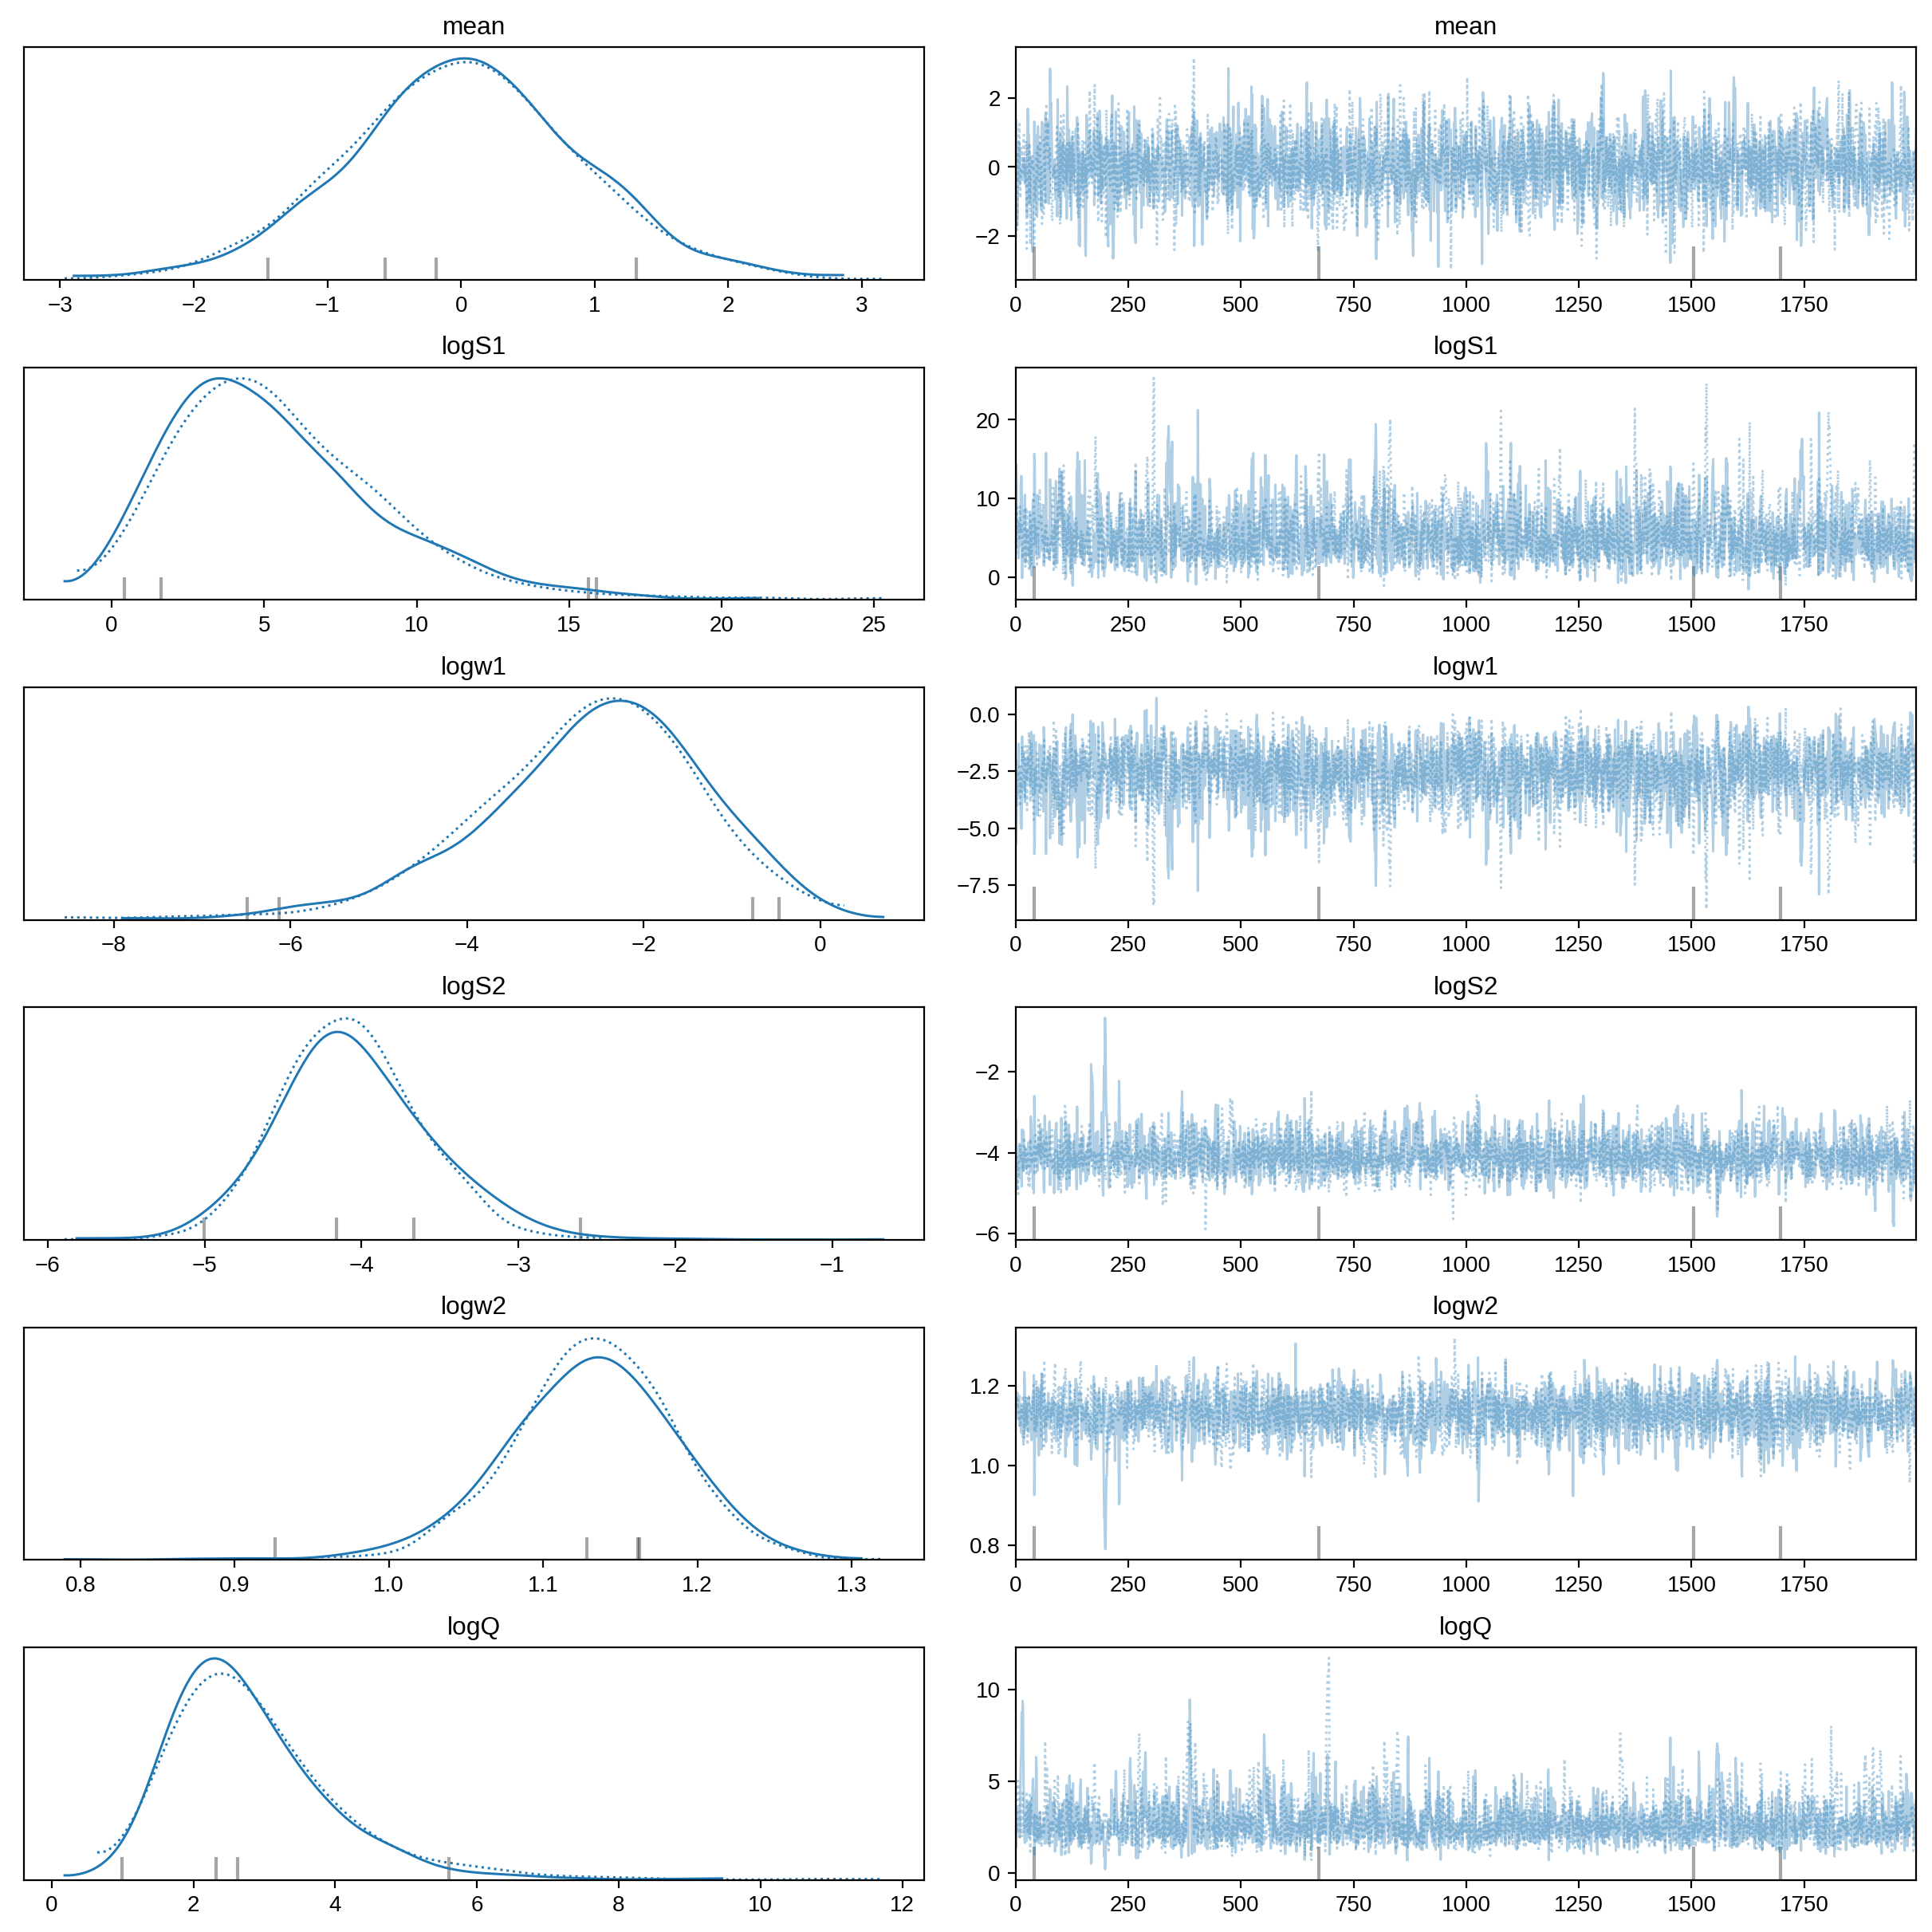

In [9]:
pm.traceplot(trace)
pm.summary(trace)

That all looks pretty good, but I like to make two other results plots: (1) a [corner plot](https://corner.readthedocs.io) and (2) a posterior predictive plot.

The corner plot is easy using `pymc3.trace_to_dataframe` and I find it useful for understanding the covariances between parameters when debugging.

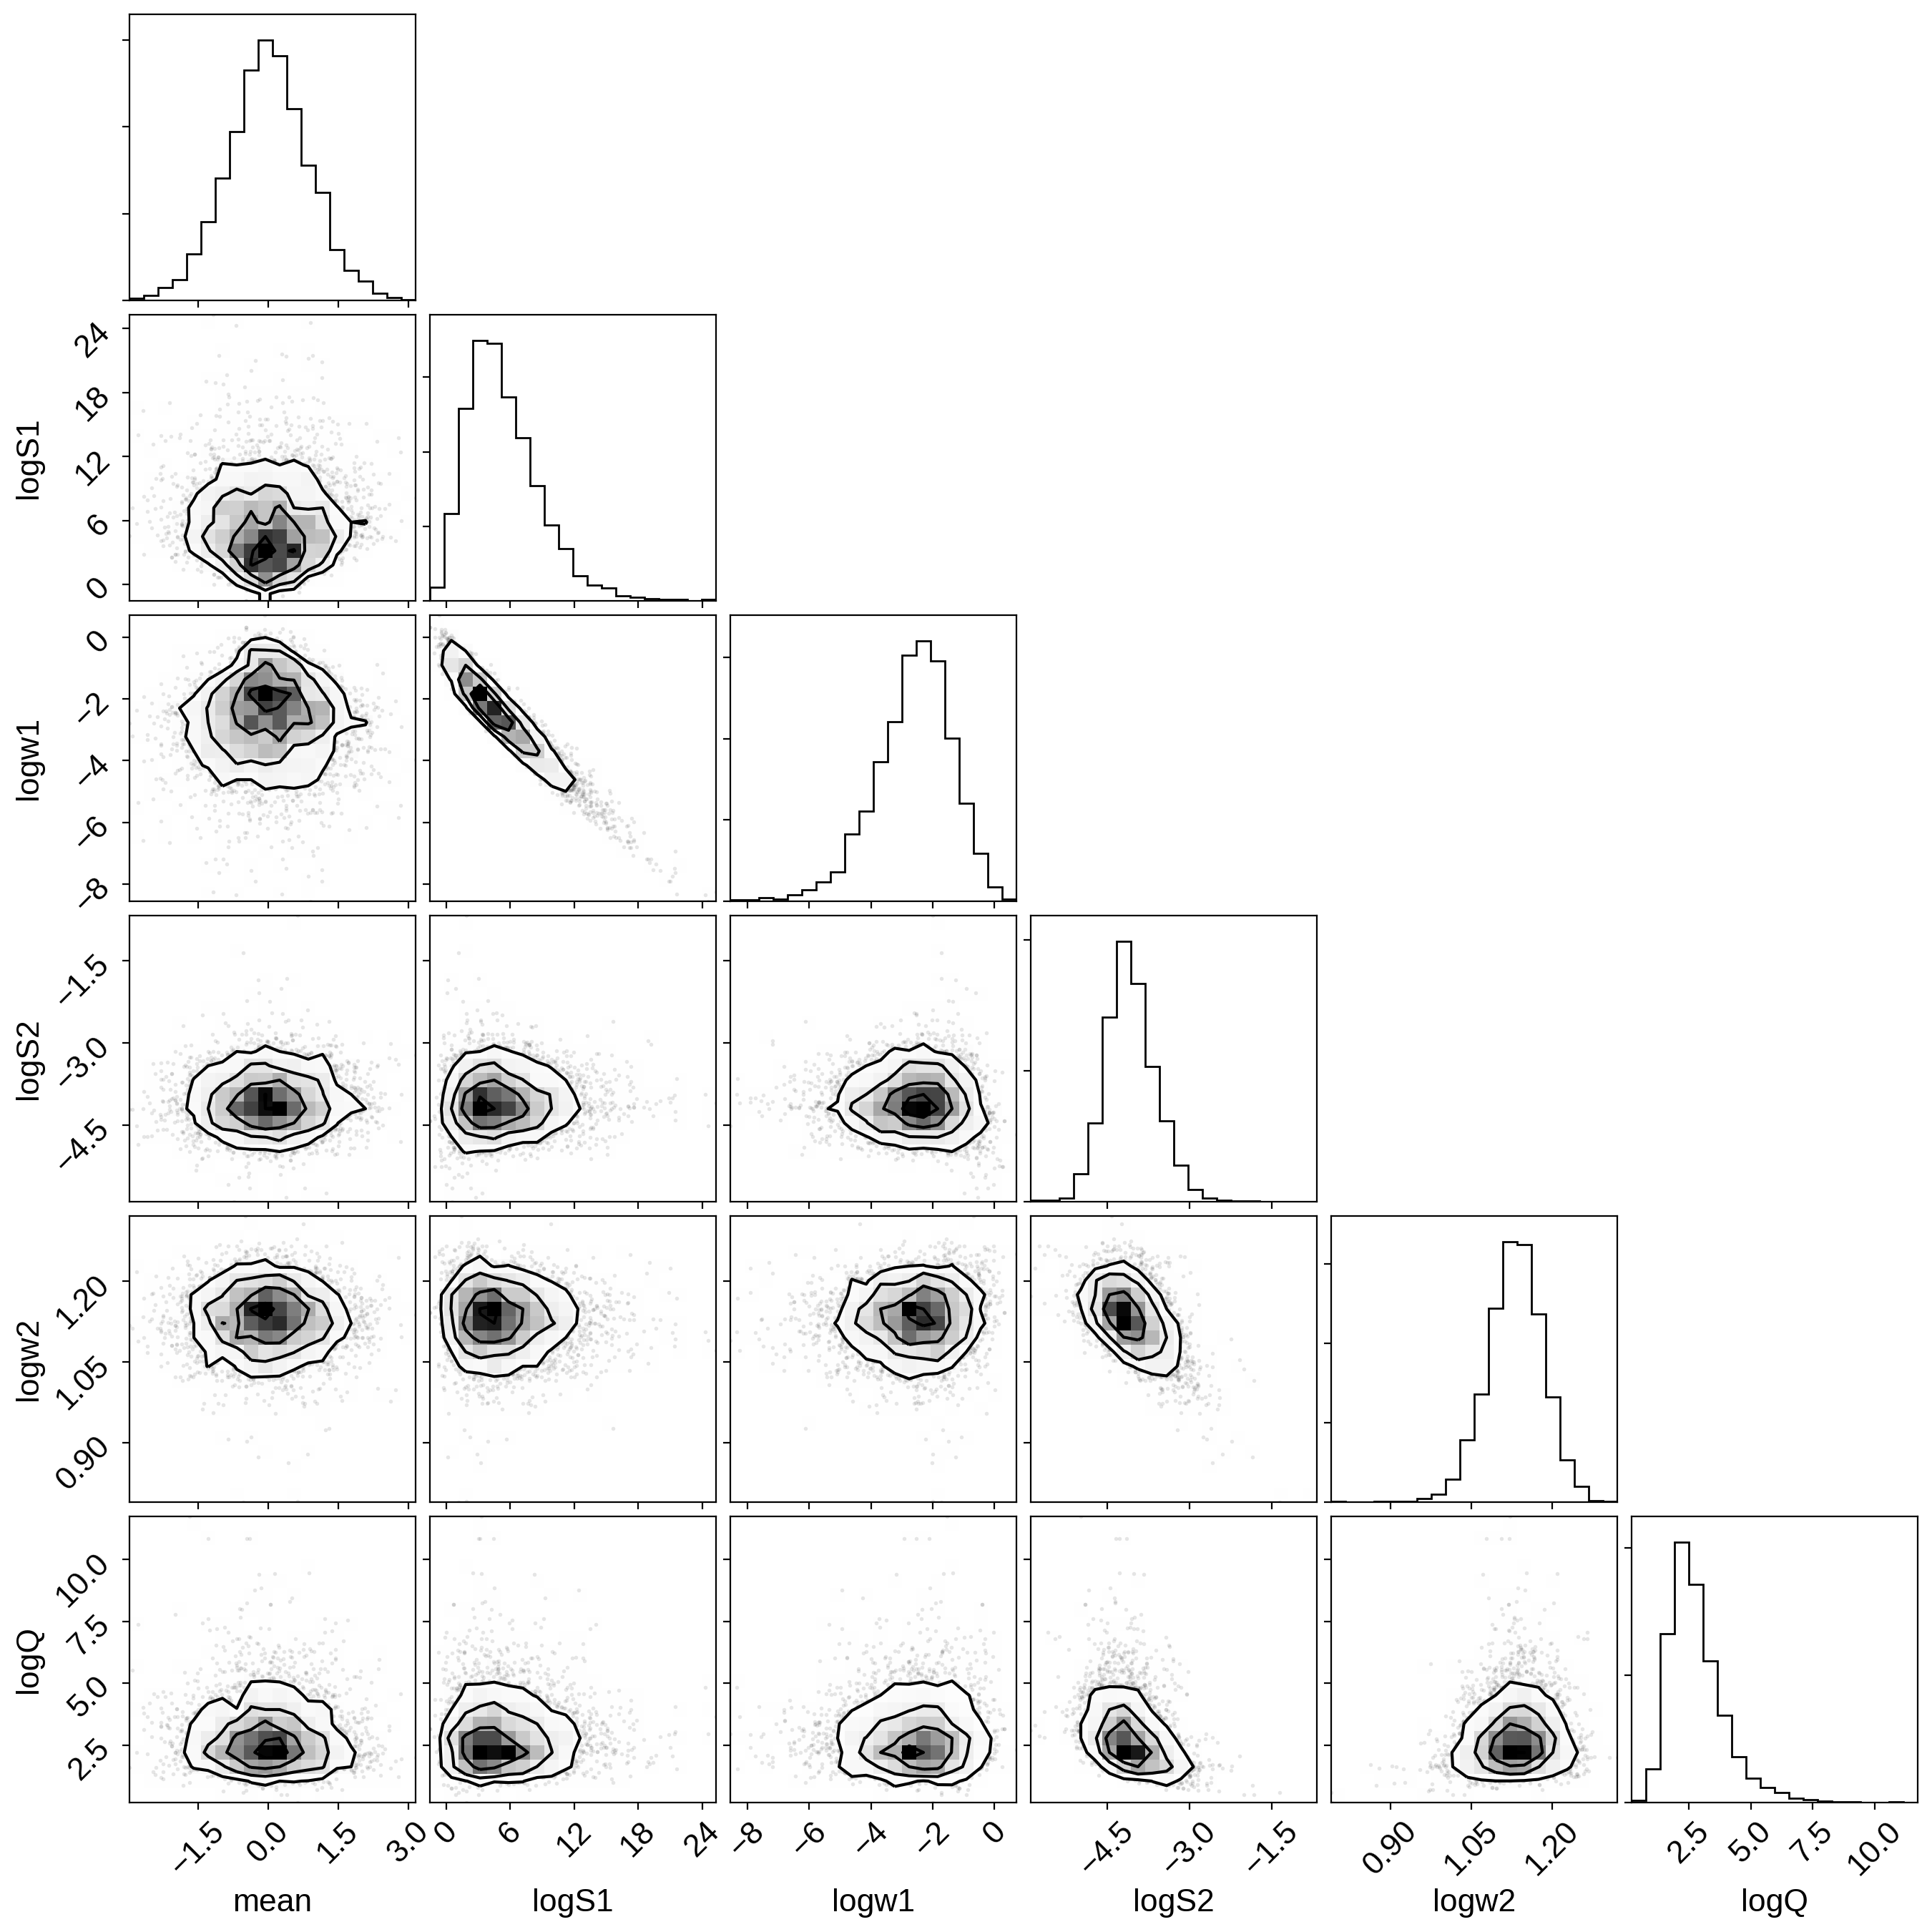

In [10]:
import corner

samples = pm.trace_to_dataframe(trace)
_ = corner.corner(samples)

The "posterior predictive" plot that I like to make isn't the same as a "posterior predictive check" (which can be a good thing to do too).
Instead, I like to look at the predictions of the model in the space of the data.
We could have saved these predictions using a `pymc3.Deterministic` distribution, but that adds some overhead to each evaluation of the model so instead, we can use :func:`exoplanet.utils.get_samples_from_trace` to loop over a few random samples from the chain and then the :func:`exoplanet.eval_in_model` function to evaluate the prediction just for those samples.

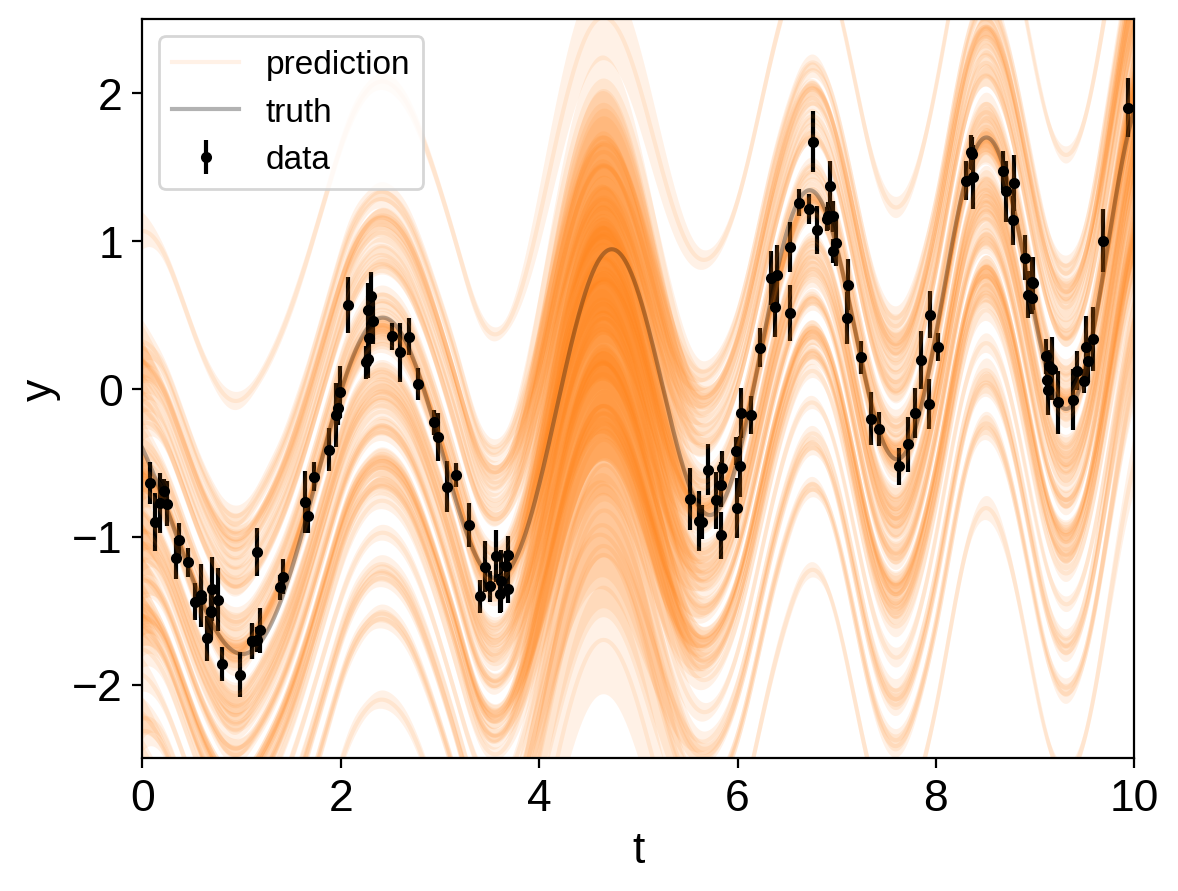

In [11]:
# Generate 50 realizations of the prediction sampling randomly from the chain
N_pred = 50
pred_mu = np.empty((N_pred, len(true_t)))
pred_var = np.empty((N_pred, len(true_t)))
with model:
    pred = gp.predict(true_t, return_var=True)
    for i, sample in enumerate(xo.get_samples_from_trace(trace, size=N_pred)):
        pred_mu[i], pred_var[i] = xo.eval_in_model(pred, sample)

# Plot the predictions
for i in range(len(pred_mu)):
    mu = pred_mu[i]
    sd = np.sqrt(pred_var[i])
    label = None if i else "prediction"
    art = plt.fill_between(true_t, mu + sd, mu - sd, color="C1", alpha=0.1)
    art.set_edgecolor("none")
    plt.plot(true_t, mu, color="C1", label=label, alpha=0.1)

plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, label="data")
plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3, label="truth")
plt.legend(fontsize=12, loc=2)
plt.xlabel("t")
plt.ylabel("y")
plt.xlim(0, 10)
_ = plt.ylim(-2.5, 2.5)

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [12]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:exoplanet, exoplanet:foremanmackey17,
exoplanet:foremanmackey18, exoplanet:pymc3, exoplanet:theano}.


In [13]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Ian Czekala and Rodrigo Luger and
            Eric Agol and Geert Barentsen and Tom Barclay},
   title = {exoplanet-dev/exoplanet v0.2.4},
   month = dec,
    year = 2019,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
